# Health Insurance Predictor

## 1. Loading Libraries & Importing Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from xgboost import XGBRegressor

In [2]:
!pip install xgboost

In [3]:
df = pd.read_excel('premiums_young.xlsx')

In [4]:
df.shape

(20096, 14)

In [5]:
df.head()

,Unnamed: 0,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
1,9,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050
2,10,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857
3,16,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684
4,19,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712


## 2. Data Cleaning & EDA

In [6]:
df.columns

Index(['Unnamed: 0', 'Age', 'Gender', 'Region', 'Marital_status',
       'Number Of Dependants', 'BMI_Category', 'Smoking_Status',
       'Employment_Status', 'Income_Level', 'Income_Lakhs', 'Medical History',
       'Insurance_Plan', 'Annual_Premium_Amount'],
      dtype='object')

In [7]:
# Standardizing column names

df.columns = df.columns.str.replace(' ', '_').str.lower()
df.head()

,unnamed:_0,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
1,9,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050
2,10,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857
3,16,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684
4,19,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20096 entries, 0 to 20095
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   unnamed:_0             20096 non-null  int64 
 1   age                    20096 non-null  int64 
 2   gender                 20096 non-null  object
 3   region                 20096 non-null  object
 4   marital_status         20096 non-null  object
 5   number_of_dependants   20096 non-null  int64 
 6   bmi_category           20096 non-null  object
 7   smoking_status         20094 non-null  object
 8   employment_status      20095 non-null  object
 9   income_level           20092 non-null  object
 10  income_lakhs           20096 non-null  int64 
 11  medical_history        20096 non-null  object
 12  insurance_plan         20096 non-null  object
 13  annual_premium_amount  20096 non-null  int64 
dtypes: int64(5), object(9)
memory usage: 2.1+ MB


### Handling Missing & Duplicate Values

In [9]:
df.isna().sum()

unnamed:_0               0
age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           2
employment_status        1
income_level             4
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

* Since, the number of null values are less, we will proceed in dropping those records.

In [10]:
df.dropna(inplace=True)
df.isna().sum()

unnamed:_0               0
age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [11]:
df.duplicated().sum()

np.int64(0)

In [12]:
df.describe()

,unnamed:_0,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20090.000000,20090.000000,20090.000000,20090.000000,20090.000000
mean,24962.130513,21.494375,0.718019,22.510851,8142.096267
std,14438.360343,2.294052,0.940713,23.420493,2749.906347
min,4.000000,18.000000,-3.000000,1.000000,3501.000000
25%,12350.250000,19.000000,0.000000,6.000000,6022.250000
50%,24903.500000,22.000000,0.000000,16.000000,7939.000000
75%,37404.750000,23.000000,1.000000,31.000000,9561.000000
max,49998.000000,25.000000,3.000000,790.000000,18186.000000


In [13]:
df[df['number_of_dependants'] < 0]['number_of_dependants'].unique()

array([-3, -1])

* Since, the number of dependants cannot be negative, we will convert those values into positive numbers.

In [14]:
df['number_of_dependants'] = df['number_of_dependants'].abs()

In [15]:
df.describe()

,unnamed:_0,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20090.000000,20090.000000,20090.000000,20090.000000,20090.000000
mean,24962.130513,21.494375,0.722598,22.510851,8142.096267
std,14438.360343,2.294052,0.937200,23.420493,2749.906347
min,4.000000,18.000000,0.000000,1.000000,3501.000000
25%,12350.250000,19.000000,0.000000,6.000000,6022.250000
50%,24903.500000,22.000000,0.000000,16.000000,7939.000000
75%,37404.750000,23.000000,1.000000,31.000000,9561.000000
max,49998.000000,25.000000,3.000000,790.000000,18186.000000


### Univariate Analysis of Numeric Columns

In [16]:
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
numeric_columns

Index(['unnamed:_0', 'age', 'number_of_dependants', 'income_lakhs',
       'annual_premium_amount'],
      dtype='object')

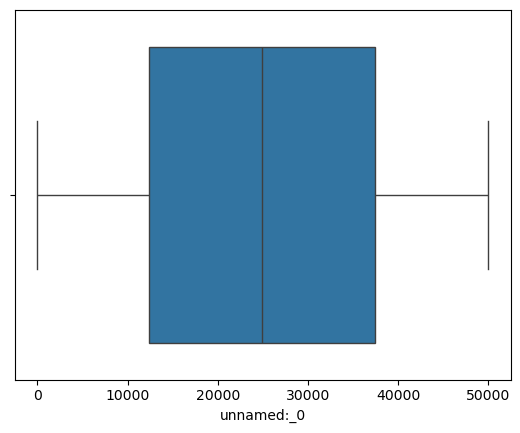

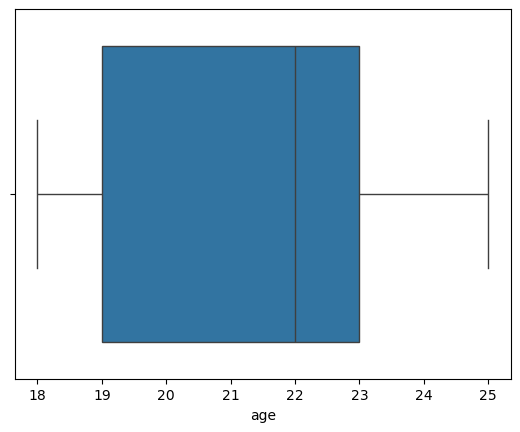

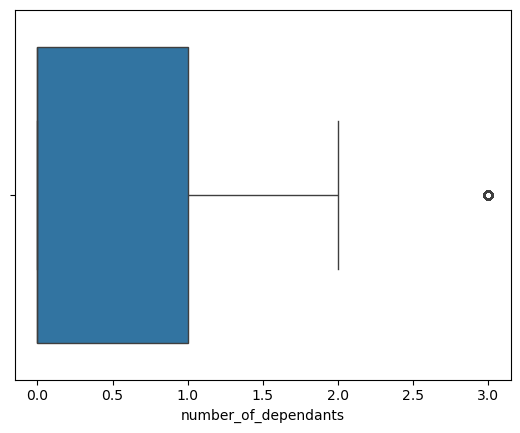

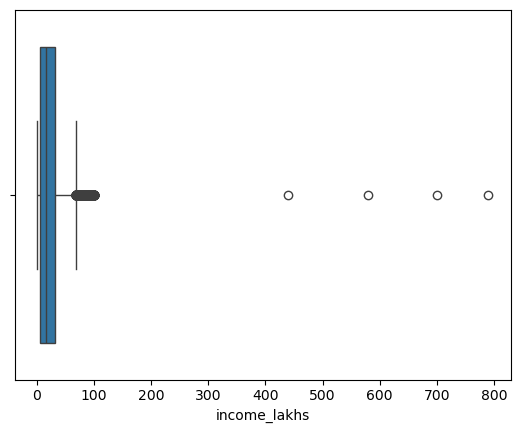

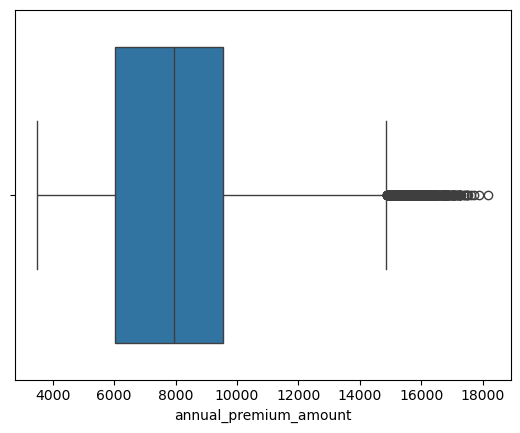

In [17]:
# Visualizing distribution of each columns using box plot

for col in numeric_columns:
    sns.boxplot(x=df[col])
    plt.show()

### Treating Outliers

In [18]:
df[df['age'] > 100]['age'].unique()

array([], dtype=int64)

In [19]:
df1 = df[df['age'] <= 100]

In [20]:
df1.age.describe()

count    20090.000000
mean        21.494375
std          2.294052
min         18.000000
25%         19.000000
50%         22.000000
75%         23.000000
max         25.000000
Name: age, dtype: float64

In [21]:
# Handling outiers in income_lakhs column

def get_iqr_bound(col):
    Q1, Q3 = col.quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    return lower, upper

lower, upper = get_iqr_bound(df1['income_lakhs'])
lower, upper

(-31.5, 68.5)

In [22]:
df1[df1['income_lakhs'] > upper].shape

(1295, 14)

* Since, these records appears to be legitimate, we can't remove it using IQR records. We will try using simple quantile method.

In [23]:
quantile_threshold = df1['income_lakhs'].quantile(0.999)
print(quantile_threshold)

100.0


In [24]:
df1[df1['income_lakhs'] > quantile_threshold].shape

(4, 14)

* Since, there are only few records, we will remove it from our dataset.

In [25]:
df2 = df1[df1['income_lakhs'] <= quantile_threshold]
df2.shape

(20086, 14)

IndexError: index 2 is out of bounds for axis 0 with size 2

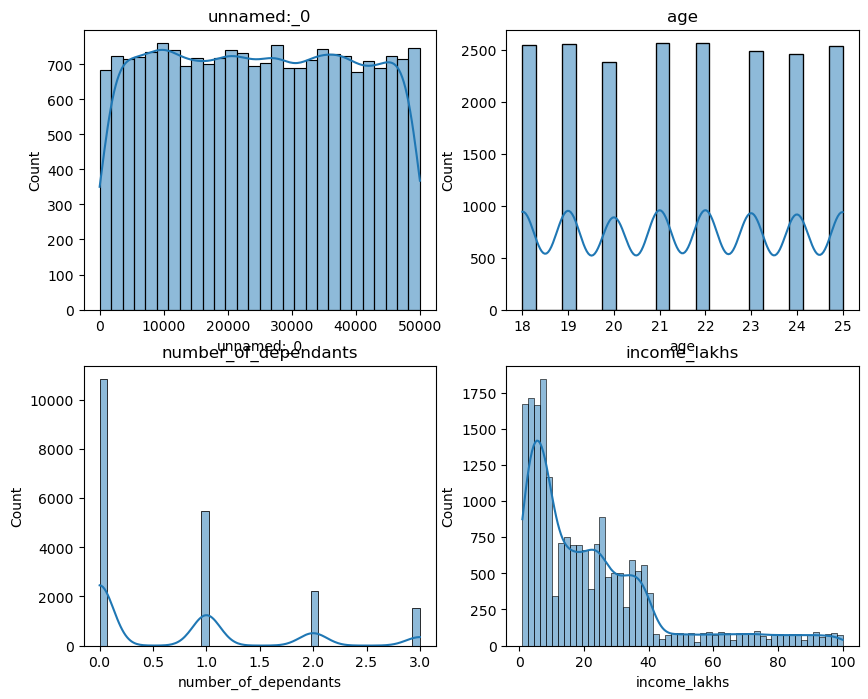

In [26]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))  # Adjust the size as necessary

for i, column in enumerate(numeric_columns):
    ax = axs[i//2, i%2]  # Determines the position of the subplot in the grid
    sns.histplot(df2[column], kde=True, ax=ax)
    ax.set_title(column)

plt.tight_layout()
plt.show()

In [27]:
df2.head(3)

,unnamed:_0,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
1,9,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050
2,10,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857


### Bivariate Analysis

In [28]:
numeric_columns

Index(['unnamed:_0', 'age', 'number_of_dependants', 'income_lakhs',
       'annual_premium_amount'],
      dtype='object')

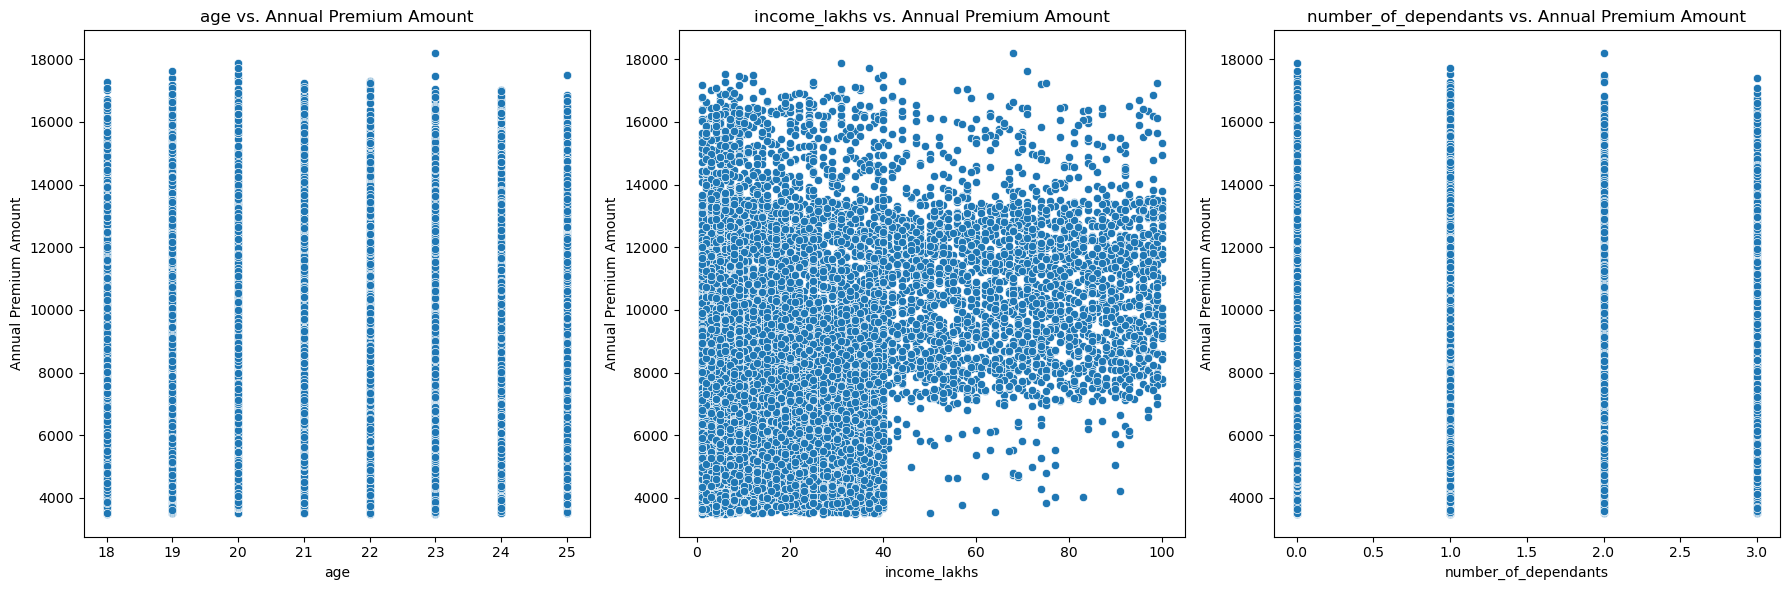

In [29]:
numeric_features = ['age', 'income_lakhs', 'number_of_dependants']

fig, axes = plt.subplots(1, len(numeric_features), figsize=(18, 6))  # Adjust figure size as necessary

for ax, column in zip(axes, numeric_features):
    sns.scatterplot(x=df2[column], y=df2['annual_premium_amount'], ax=ax)
    ax.set_title(f'{column} vs. Annual Premium Amount')
    ax.set_xlabel(column)
    ax.set_ylabel('Annual Premium Amount')

plt.tight_layout()  # Adjust layout
plt.show()

### Analyzing Categorical Columns

In [30]:
df2.head(1)

,unnamed:_0,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365


In [31]:
categorical_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status', 'income_level', 'medical_history', 'insurance_plan']
categorical_cols

['gender',
 'region',
 'marital_status',
 'bmi_category',
 'smoking_status',
 'employment_status',
 'income_level',
 'medical_history',
 'insurance_plan']

In [32]:
for col in categorical_cols:
    print(col, ':', df2[col].unique())

gender : ['Male' 'Female']
region : ['Northeast' 'Northwest' 'Southeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Overweight' 'Underweight' 'Normal' 'Obesity']
smoking_status : ['Regular' 'No Smoking' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status : ['Self-Employed' 'Freelancer' 'Salaried']
income_level : ['> 40L' '<10L' '10L - 25L' '25L - 40L']
medical_history : ['High blood pressure' 'No Disease' 'Diabetes & High blood pressure'
 'Diabetes & Heart disease' 'Diabetes' 'Diabetes & Thyroid'
 'Heart disease' 'Thyroid' 'High blood pressure & Heart disease']
insurance_plan : ['Silver' 'Bronze' 'Gold']


In [33]:
# Handling data inconsistencies

df2['smoking_status'].replace({
    'Smoking=0': 'No Smoking',
    'Does Not Smoke': 'No Smoking',
    'Not Smoking': 'No Smoking'
}, inplace=True)

df2['smoking_status'].unique()

C:\Users\win10\AppData\Local\Temp\ipykernel_4420\2115574736.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['smoking_status'].replace({
C:\Users\win10\AppData\Local\Temp\ipykernel_4420\2115574736.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['smoking_status'].replace({


array(['Regular', 'No Smoking', 'Occasional'], dtype=object)

### Univariate Analysis of Categorical Columns

In [34]:
# Analyzing distribution of gender

pct_count = df2['gender'].value_counts(normalize=True)*100
pct_count

gender
Male      55.038335
Female    44.961665
Name: proportion, dtype: float64

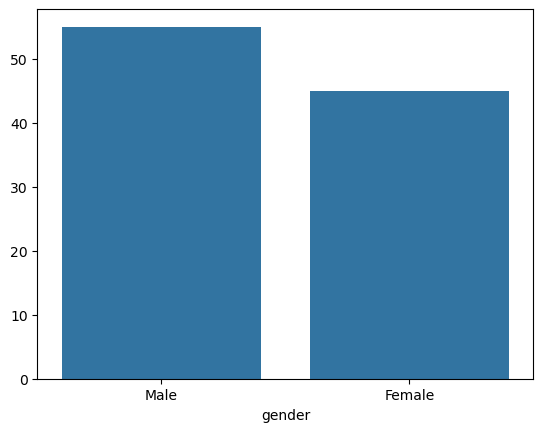

In [35]:
sns.barplot(x=pct_count.index, y=pct_count.values)
plt.show()

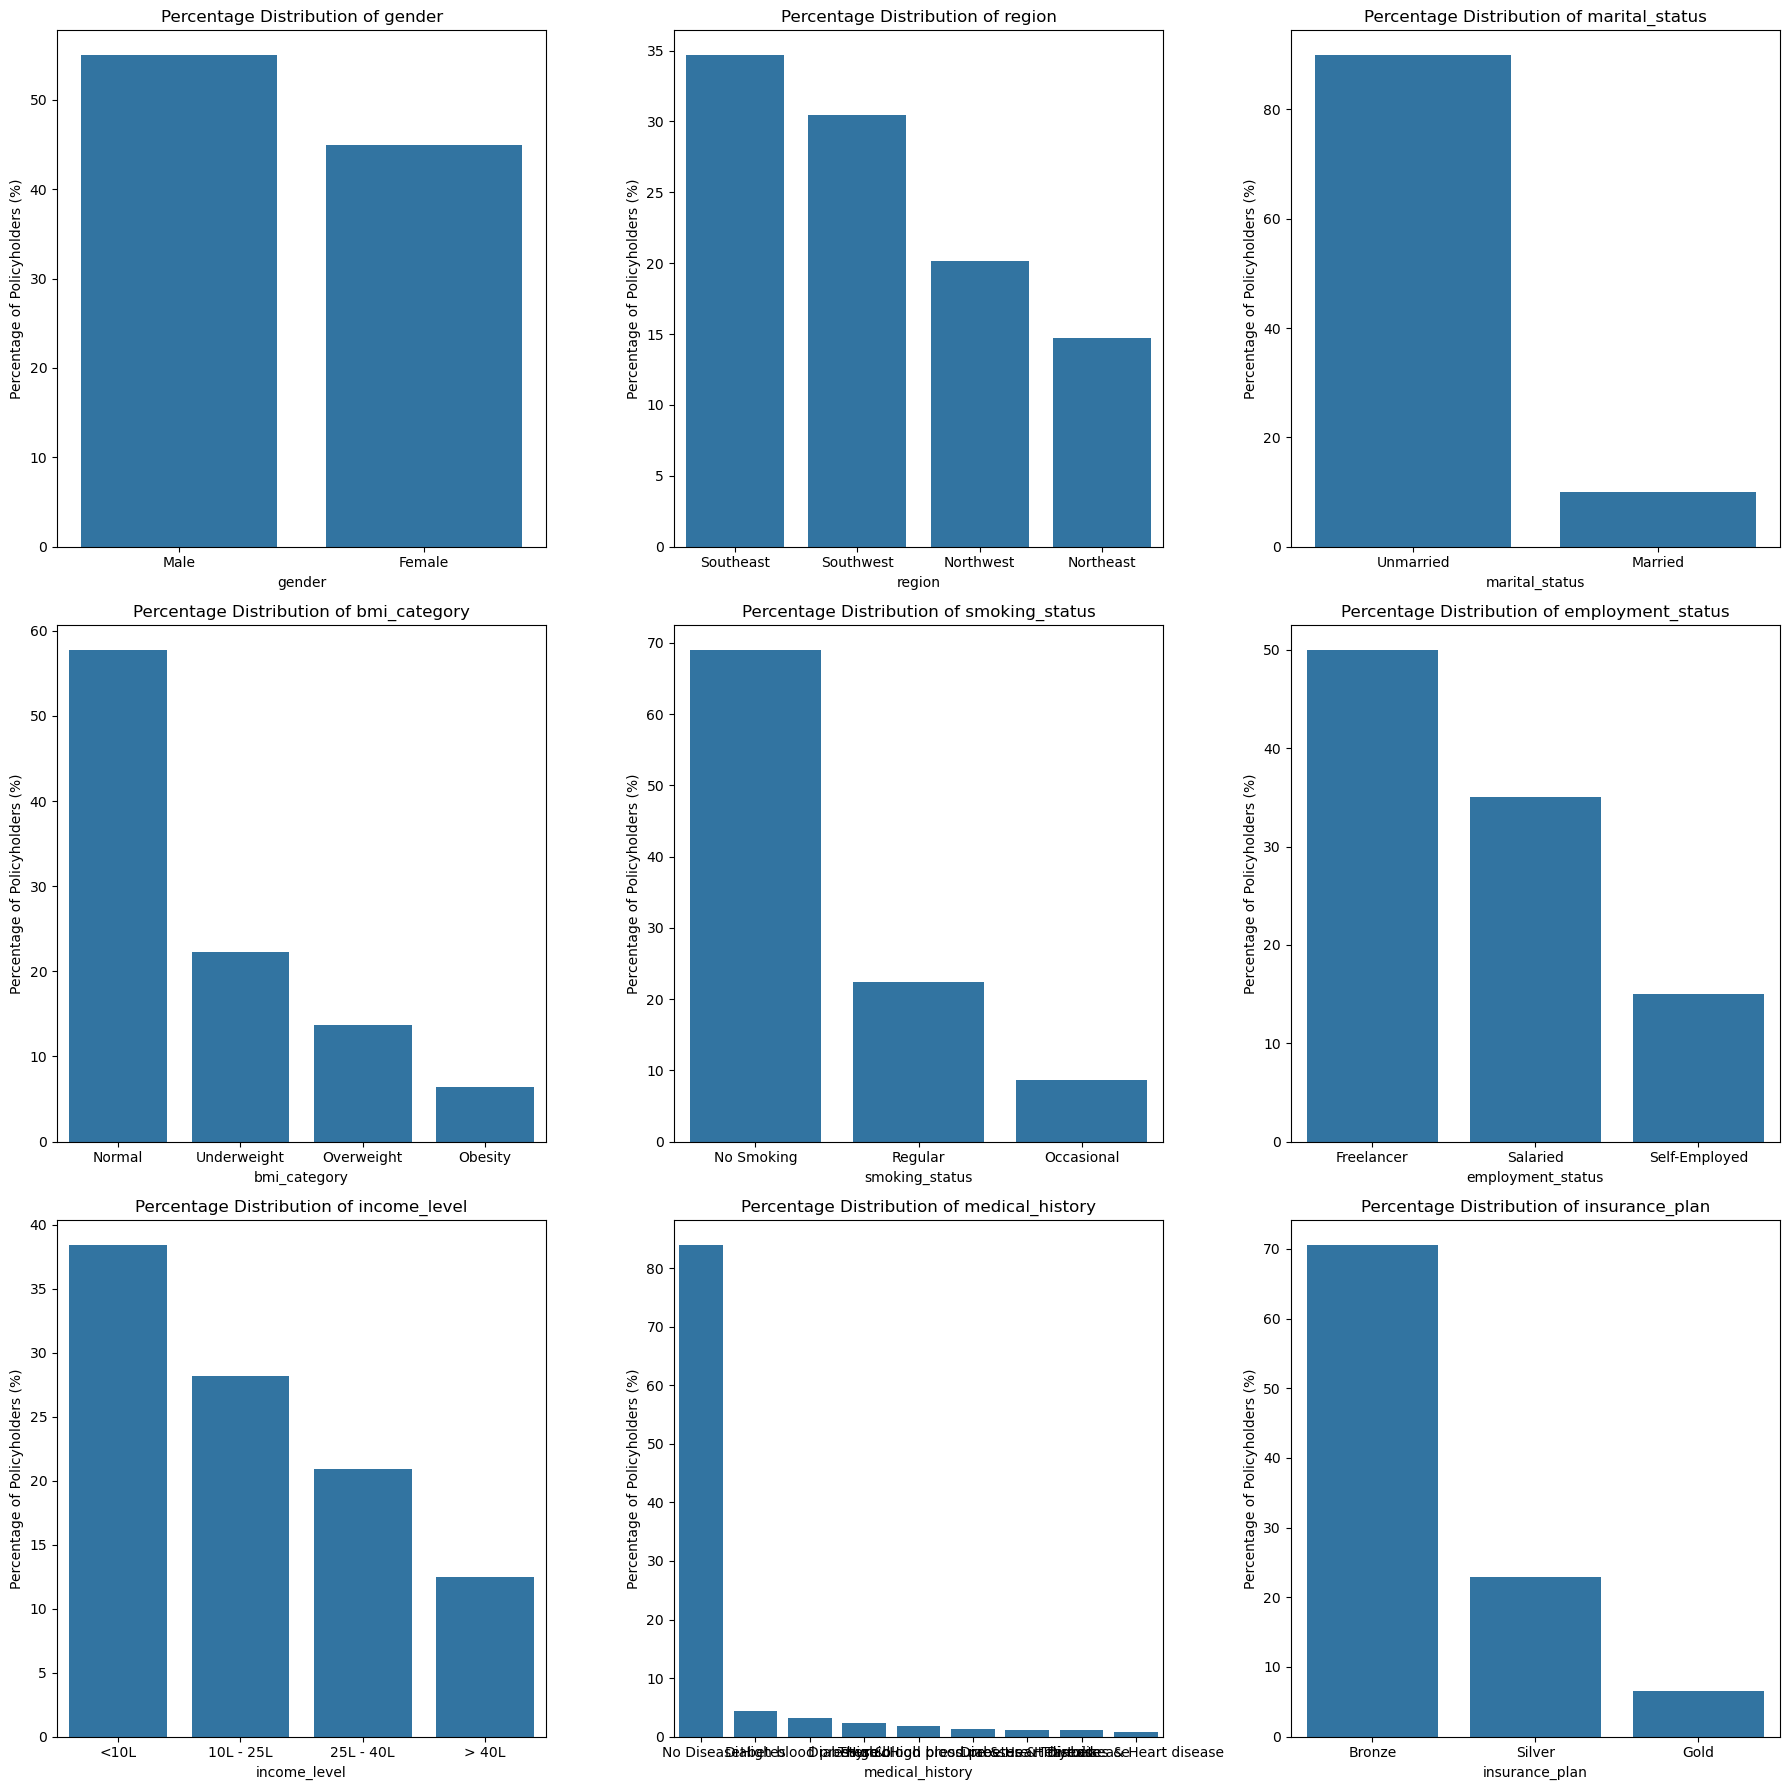

In [36]:
fig, axes = plt.subplots(3, 3, figsize=(18, 18))  # Adjust figure size as necessary
axes = axes.flatten()  # Flatten the 2D array of axes into 1D for easier iteration

for ax, column in zip(axes, categorical_cols):
    # Calculate the percentage distribution of each category
    category_counts = df2[column].value_counts(normalize=True) * 100  # normalize=True gives the relative frequencies
    
    # Plotting the distribution using barplot
    sns.barplot(x=category_counts.index, y=category_counts.values, ax=ax)
    ax.set_title(f'Percentage Distribution of {column}')
    ax.set_ylabel('Percentage of Policyholders (%)')
    ax.set_xlabel(column)  # Set xlabel to the column name for clarity

plt.tight_layout()  # Adjusts plot parameters for better fit in the figure window
plt.show()

### Bivariate Analysis of Categorical Columns

In [37]:
# Cross tabulation of income level and insurance plan
crosstab = pd.crosstab(df2['income_level'], df2['insurance_plan'])
print(crosstab)

insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L         4508   326     828
25L - 40L         3382   209     608
<10L              6172   404    1145
> 40L              115   366    2023


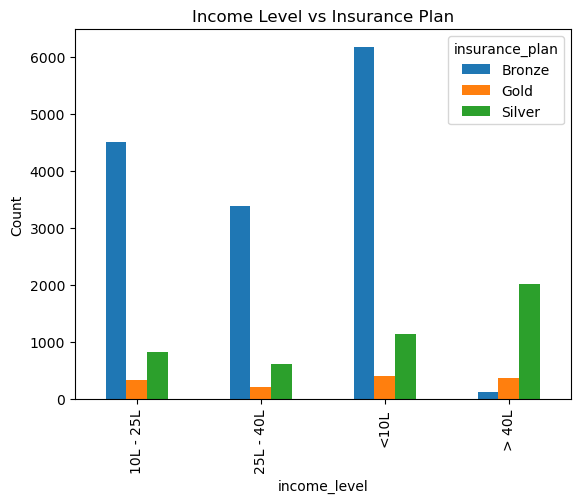

In [38]:
# Plotting crosstab
crosstab.plot(kind='bar')
plt.title('Income Level vs Insurance Plan')
plt.ylabel('Count')
plt.show()

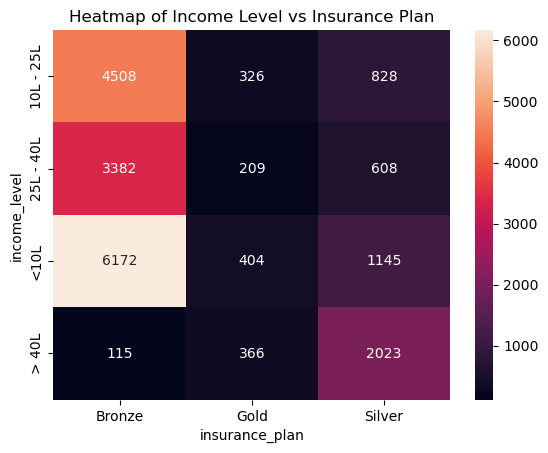

In [39]:
sns.heatmap(crosstab, annot=True, fmt='d')
plt.title('Heatmap of Income Level vs Insurance Plan')
plt.show()

## 3. Feature Engineering

In [40]:
df2.head(2)

,unnamed:_0,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
1,9,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050


### Calculating Risk Scores

In [41]:
df2['medical_history'].unique()

array(['High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Diabetes & Heart disease',
       'Diabetes', 'Diabetes & Thyroid', 'Heart disease', 'Thyroid',
       'High blood pressure & Heart disease'], dtype=object)

In [42]:
risk_scores = {
    'diabetes': 6,
    'heart disease': 8,
    'high blood pressure': 6,
    'thyroid': 5,
    'no disease': 0,
    'none': 0
}

df2[['disease1', 'disease2']] = df2['medical_history'].str.split(' & ', expand=True).apply(lambda x: x.str.lower())
df2['disease1'].fillna('none', inplace=True)
df2['disease2'].fillna('none', inplace=True)
df2['total_risk_score'] = 0

C:\Users\win10\AppData\Local\Temp\ipykernel_4420\1568185411.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[['disease1', 'disease2']] = df2['medical_history'].str.split(' & ', expand=True).apply(lambda x: x.str.lower())
C:\Users\win10\AppData\Local\Temp\ipykernel_4420\1568185411.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[['disease1', 'disease2']] = df2['medical_history'].str.split(' & ', expand=True).apply(lambda x: x.str.lower())
C:\Users\win10\AppData\Local\Temp\ipykernel_4420\15681

In [43]:
df2.head()

,unnamed:_0,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score
0,4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,high blood pressure,none,0
1,9,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,no disease,none,0
2,10,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,no disease,none,0
3,16,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684,no disease,none,0
4,19,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712,no disease,none,0


In [44]:
for disease in ['disease1', 'disease2']:
    df2['total_risk_score'] += df2[disease].map(risk_scores)

df2.head()

C:\Users\win10\AppData\Local\Temp\ipykernel_4420\1880873791.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['total_risk_score'] += df2[disease].map(risk_scores)
C:\Users\win10\AppData\Local\Temp\ipykernel_4420\1880873791.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['total_risk_score'] += df2[disease].map(risk_scores)


,unnamed:_0,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score
0,4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,high blood pressure,none,6
1,9,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,no disease,none,0
2,10,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,no disease,none,0
3,16,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684,no disease,none,0
4,19,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712,no disease,none,0


In [45]:
# Normalizing risk scores

min_score = df2['total_risk_score'].min()
max_score = df2['total_risk_score'].max()
df2['normalized_risk_score'] = (df2['total_risk_score'] - min_score)/(max_score - min_score)
df2.head(3)

C:\Users\win10\AppData\Local\Temp\ipykernel_4420\163394873.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['normalized_risk_score'] = (df2['total_risk_score'] - min_score)/(max_score - min_score)


,unnamed:_0,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,high blood pressure,none,6,0.428571
1,9,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,no disease,none,0,0.000000
2,10,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,no disease,none,0,0.000000


### Encoding Text Columns

In [46]:
df2['insurance_plan'].unique()

array(['Silver', 'Bronze', 'Gold'], dtype=object)

In [47]:
df2['insurance_plan'] = df2['insurance_plan'].map({'Bronze': 1, 'Silver': 2, 'Gold': 3})

C:\Users\win10\AppData\Local\Temp\ipykernel_4420\2544073899.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['insurance_plan'] = df2['insurance_plan'].map({'Bronze': 1, 'Silver': 2, 'Gold': 3})


In [48]:
df2['income_level'].unique()

array(['> 40L', '<10L', '10L - 25L', '25L - 40L'], dtype=object)

In [49]:
df2['income_level'] = df2['income_level'].map({'<10L': 1, '10L - 25L': 2, '25L - 40L': 3, '> 40L': 4})

C:\Users\win10\AppData\Local\Temp\ipykernel_4420\1698088322.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['income_level'] = df2['income_level'].map({'<10L': 1, '10L - 25L': 2, '25L - 40L': 3, '> 40L': 4})


In [50]:
df2.head()

,unnamed:_0,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,4,99,High blood pressure,2,13365,high blood pressure,none,6,0.428571
1,9,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,1,3,No Disease,2,11050,no disease,none,0,0.000000
2,10,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,4,97,No Disease,2,11857,no disease,none,0,0.000000
3,16,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,2,15,No Disease,1,5684,no disease,none,0,0.000000
4,19,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,2,14,No Disease,1,5712,no disease,none,0,0.000000


In [51]:
nominal_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status',  'employment_status']
df3 = pd.get_dummies(df2, columns=nominal_cols, drop_first=True, dtype=int)
df3.head(4)

,unnamed:_0,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,4,18,0,4,99,High blood pressure,2,13365,high blood pressure,none,...,0,0,1,0,1,0,0,1,0,1
1,9,22,0,1,3,No Disease,2,11050,no disease,none,...,0,0,1,0,0,1,0,0,0,0
2,10,21,0,4,97,No Disease,2,11857,no disease,none,...,1,0,1,0,0,0,0,1,1,0
3,16,25,0,2,15,No Disease,1,5684,no disease,none,...,1,0,1,0,0,0,0,0,0,0


In [52]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20086 entries, 0 to 20095
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   unnamed:_0                       20086 non-null  int64  
 1   age                              20086 non-null  int64  
 2   number_of_dependants             20086 non-null  int64  
 3   income_level                     20086 non-null  int64  
 4   income_lakhs                     20086 non-null  int64  
 5   medical_history                  20086 non-null  object 
 6   insurance_plan                   20086 non-null  int64  
 7   annual_premium_amount            20086 non-null  int64  
 8   disease1                         20086 non-null  object 
 9   disease2                         20086 non-null  object 
 10  total_risk_score                 20086 non-null  int64  
 11  normalized_risk_score            20086 non-null  float64
 12  gender_Male            

### Feature Selection

In [53]:
df4 = df3.drop(['medical_history', 'disease1', 'disease2', 'total_risk_score'], axis=1)
df4.head(2)

,unnamed:_0,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,4,18,0,4,99,2,13365,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,9,22,0,1,3,2,11050,0.000000,0,1,0,0,1,0,0,1,0,0,0,0


In [54]:
# Calculating VIF for multicollinearity

df4.columns

Index(['unnamed:_0', 'age', 'number_of_dependants', 'income_level',
       'income_lakhs', 'insurance_plan', 'annual_premium_amount',
       'normalized_risk_score', 'gender_Male', 'region_Northwest',
       'region_Southeast', 'region_Southwest', 'marital_status_Unmarried',
       'bmi_category_Obesity', 'bmi_category_Overweight',
       'bmi_category_Underweight', 'smoking_status_Occasional',
       'smoking_status_Regular', 'employment_status_Salaried',
       'employment_status_Self-Employed'],
      dtype='object')

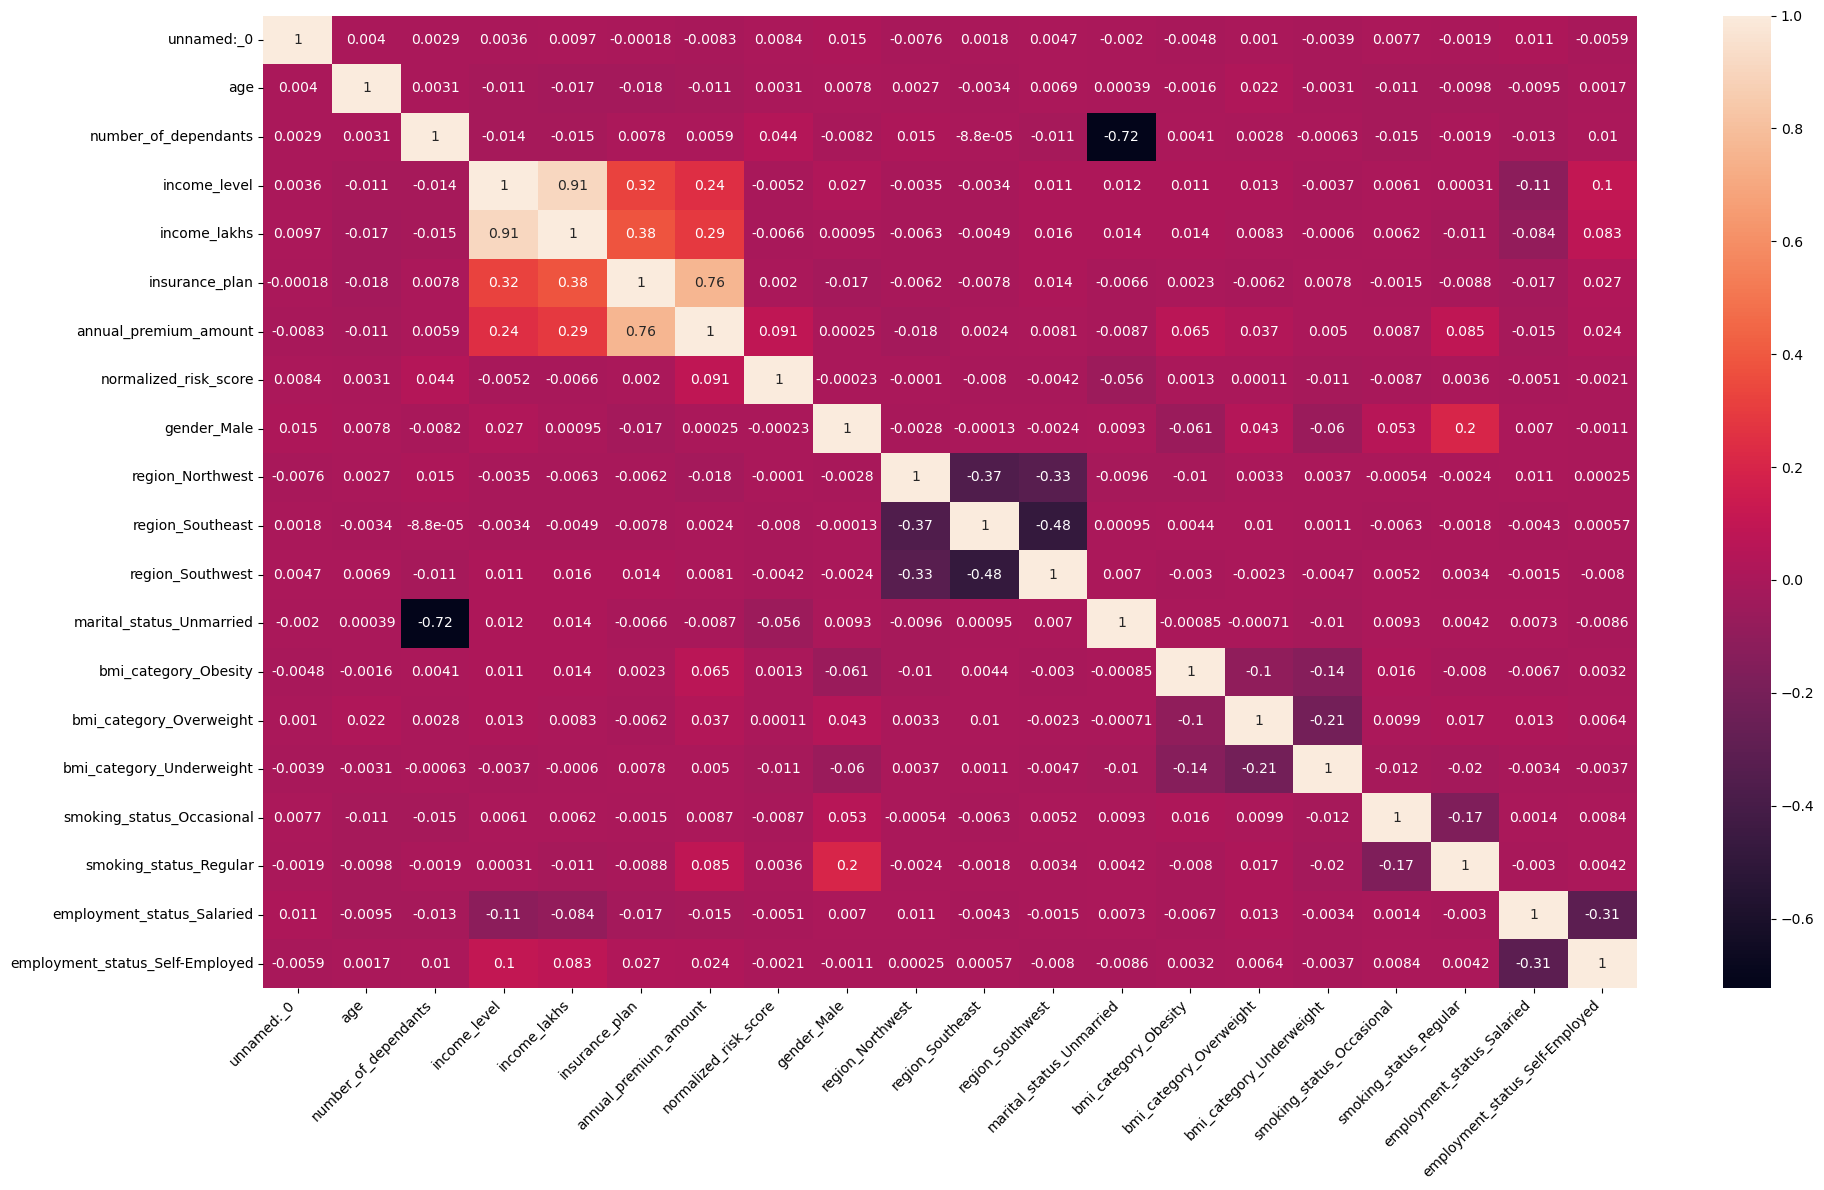

In [55]:
cm = df4.corr()

plt.figure(figsize=(20,12))
sns.heatmap(cm, annot=True)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [56]:
df4.head(3)

,unnamed:_0,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,4,18,0,4,99,2,13365,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,9,22,0,1,3,2,11050,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,10,21,0,4,97,2,11857,0.000000,0,0,1,0,1,0,0,0,0,1,1,0


In [57]:
X = df4.drop('annual_premium_amount', axis=1)
y = df4['annual_premium_amount']

cols_to_scale = ['age', 'number_of_dependants', 'income_level', 'income_lakhs', 'insurance_plan']
scaler = MinMaxScaler()

X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.describe()

,unnamed:_0,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000
mean,24965.022902,0.499211,0.240914,0.357994,0.216064,0.179578,0.092076,0.550383,0.201284,0.346958,0.304590,0.899881,0.063527,0.136513,0.222493,0.086379,0.223589,0.350045,0.149955
std,14438.231315,0.327750,0.312413,0.347481,0.219516,0.300051,0.230016,0.497467,0.400970,0.476014,0.460245,0.300167,0.243914,0.343341,0.415931,0.280929,0.416660,0.476996,0.357036
min,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12356.500000,0.142857,0.000000,0.000000,0.050505,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,24910.500000,0.571429,0.000000,0.333333,0.151515,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,37406.500000,0.714286,0.333333,0.666667,0.303030,0.500000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,49998.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [58]:
# Calculating VIF for multicollinearity

def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df

In [59]:
calculate_vif(X)

,Column,VIF
0,unnamed:_0,3.732686
1,age,3.156503
2,number_of_dependants,1.960129
3,income_level,11.928709
4,income_lakhs,11.878583
5,insurance_plan,1.592972
6,normalized_risk_score,1.155442
7,gender_Male,2.317017
8,region_Northwest,2.160607
9,region_Southeast,2.996101


In [60]:
calculate_vif(X.drop('income_level', axis=1))

,Column,VIF
0,unnamed:_0,3.732685
1,age,3.155160
2,number_of_dependants,1.957493
3,income_lakhs,2.296401
4,insurance_plan,1.587874
5,normalized_risk_score,1.155393
6,gender_Male,2.306849
7,region_Northwest,2.159676
8,region_Southeast,2.994911
9,region_Southwest,2.753184


In [61]:
# We will drop income_level due to high VIF

X_reduced = X.drop('income_level', axis=1)

## 4. Model Training

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=42)

print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

X_train: (14060, 18)
X_test: (6026, 18)
y_train: (14060,)
y_test: (6026,)


In [63]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
train_score = model_lr.score(X_train, y_train)
test_score = model_lr.score(X_test, y_test)
print(f'Train score: {train_score}, Test score: {test_score}')

Train score: 0.6038544884510226, Test score: 0.600754925502182


In [64]:
y_pred = model_lr.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print("Linear Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

Linear Regression ==> MSE:  3041840.1088727596 RMSE:  1744.0871849975733


In [65]:
model_lr.coef_

array([-1.05671439e-03,  2.40666794e+01, -2.78596168e+01,  6.10198602e+01,
        6.96965811e+03,  1.14688821e+03,  2.66019939e+00, -8.87051818e+01,
       -2.69076294e+00,  3.02359032e-01,  3.83335908e+00,  8.47698633e+02,
        3.85922193e+02,  1.86887367e+02,  2.90152152e+02,  6.32424187e+02,
        8.04225489e+00,  2.15175159e+01])

In [66]:
model_lr.intercept_

np.float64(6485.192040111075)

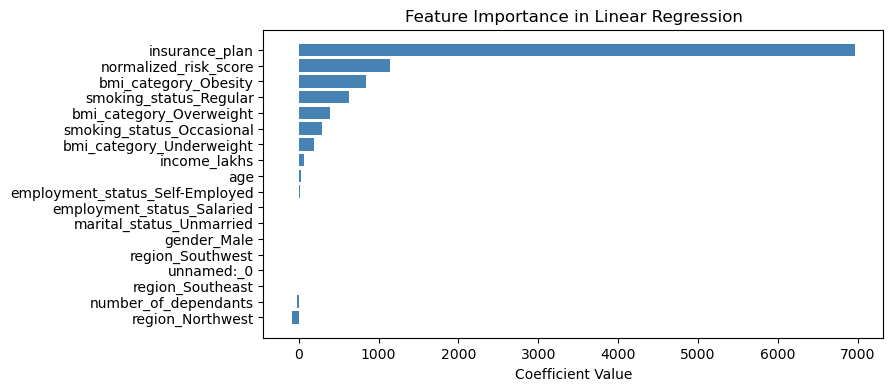

In [67]:
feature_importance = model_lr.coef_

# Create a DataFrame for easier handling
coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['Coefficients'])

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

# Plotting
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Linear Regression')
plt.show()

### Ridge Regression Model

In [68]:
model_rg = Ridge(alpha=1)
model_rg.fit(X_train, y_train)
train_score = model_rg.score(X_train, y_train)
test_score = model_rg.score(X_test, y_test)
print(f'Train score: {train_score}, Test score: {test_score}')

Train score: 0.6038540333410107, Test score: 0.6007583140508167


In [69]:
y_pred = model_rg.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print("Linear Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

Linear Regression ==> MSE:  3041814.2915895763 RMSE:  1744.0797836078418


### XGBoost

In [70]:
model_xgb = XGBRegressor(n_estimators=20, max_depth=3)
model_xgb.fit(X_train, y_train)
model_xgb.score(X_test, y_test)

0.6000106334686279

In [71]:
y_pred = model_xgb.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print("XGBoost Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

XGBoost Regression ==> MSE:  3047511.0 RMSE:  1745.7121755890919


In [72]:
model_xgb = XGBRegressor()
param_grid = {
    'n_estimators': [20, 40, 50],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
}
random_search = RandomizedSearchCV(model_xgb, param_grid, n_iter=10, cv=3, scoring='r2', random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
random_search.best_score_

np.float64(0.6006693045298258)

In [73]:
random_search.best_params_

{'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1}

In [90]:
best_model = model_lr

### Error Analysis

In [92]:
y_pred = best_model.predict(X_test)

residuals = y_pred - y_test
residuals_pct = residuals*100/y_test

results_df = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred,
    'difference': residuals,
    'difference_pct': residuals_pct
})
results_df.head()

,actual,predicted,difference,difference_pct
10489,5452,6939.250828,1487.250828,27.278995
7989,9658,7636.994909,-2021.005091,-20.925710
3113,6031,8296.763303,2265.763303,37.568617
10605,12386,10865.186622,-1520.813378,-12.278487
4204,4245,7308.251201,3063.251201,72.161395


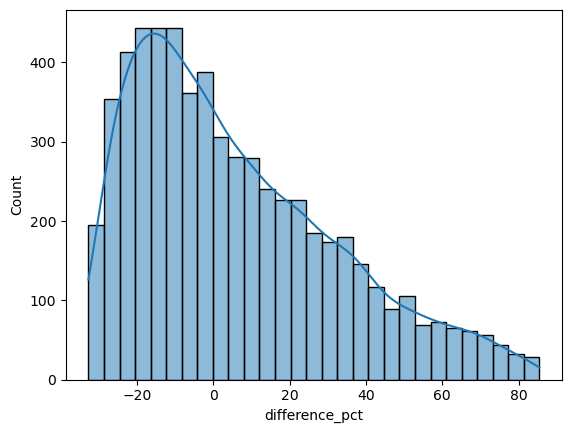

In [93]:
sns.histplot(results_df['difference_pct'], kde=True)
plt.show()

In [94]:
# Setting a threshold in residuals

extreme_error_threshold = 10
extreme_results_df = results_df[np.abs(results_df['difference_pct']) > extreme_error_threshold]
extreme_results_df.shape

(4364, 4)

In [95]:
results_df.shape

(6026, 4)

In [96]:
extreme_errors_pct = extreme_results_df.shape[0]*100/results_df.shape[0]
extreme_errors_pct

72.41951543312314

In [97]:
results_df[np.abs(results_df['difference_pct']) > 50].sort_values('difference_pct', ascending=False)

,actual,predicted,difference,difference_pct
2975,3503,6495.157226,2992.157226,85.416992
12058,3503,6487.950552,2984.950552,85.211263
10165,3501,6481.719171,2980.719171,85.139079
641,3522,6519.121059,2997.121059,85.097134
439,3611,6677.272831,3066.272831,84.914783
...,...,...,...,...
14024,4415,6634.045768,2219.045768,50.261512
13739,4270,6413.460108,2143.460108,50.198129
341,5077,7619.010492,2542.010492,50.069145
19163,4571,6858.433845,2287.433845,50.042307


* The percentage of error margins are quite high because of which we cannot deploy this model.
* We need to analyze more to understand why are we getting such a high percentage of margin errors.

In [98]:
# Finding the records from test data having high margin errors

extreme_errors_df = X_test.loc[extreme_results_df.index]
extreme_errors_df.head()

,unnamed:_0,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
10489,26034,0.428571,1.0,0.080808,0.0,0.428571,1,0,0,0,0,0,0,0,0,0,0,0
7989,19798,0.714286,0.0,0.030303,0.0,1.000000,1,0,0,1,1,0,0,0,0,0,0,0
3113,7766,0.142857,0.0,0.363636,0.0,1.000000,1,0,0,1,1,0,0,0,0,1,1,0
10605,26338,0.428571,0.0,0.515152,0.5,0.428571,1,0,1,0,1,0,1,0,0,0,0,0
4204,10367,0.000000,0.0,0.222222,0.0,0.000000,0,0,1,0,1,0,0,1,0,1,0,0


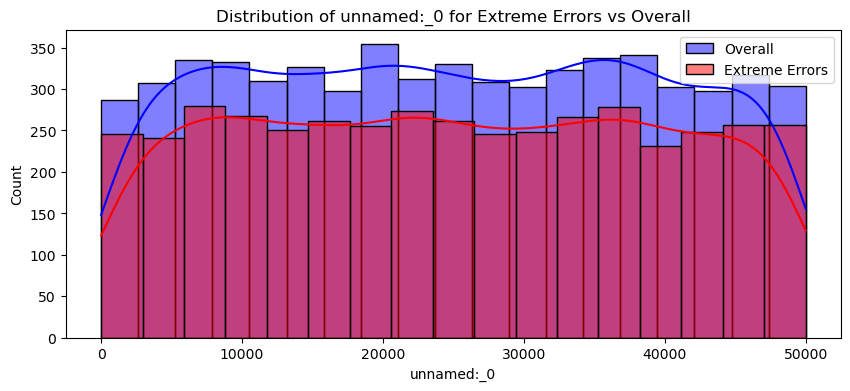

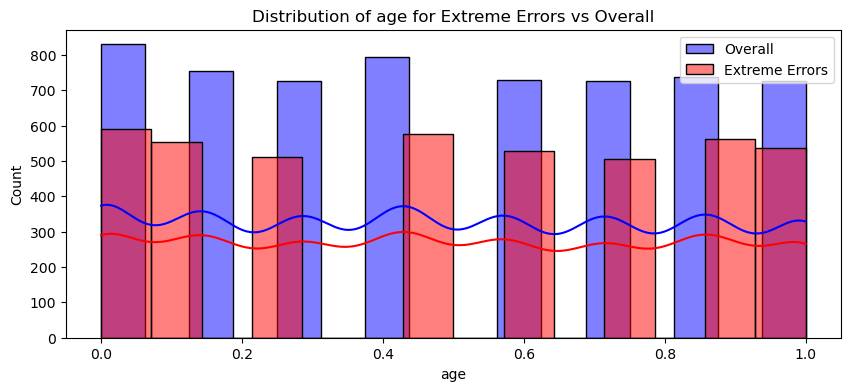

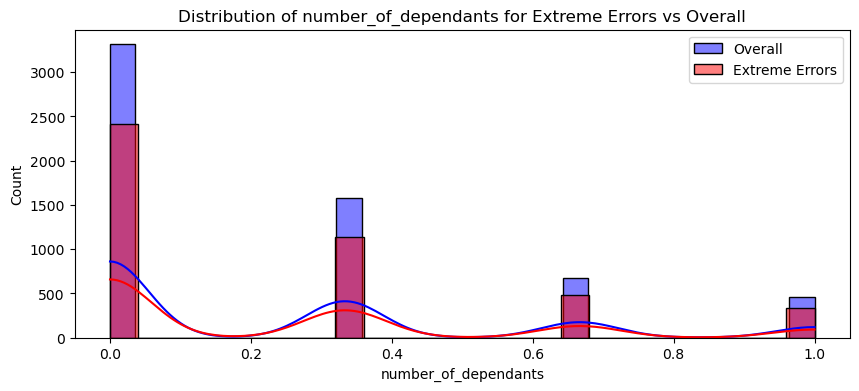

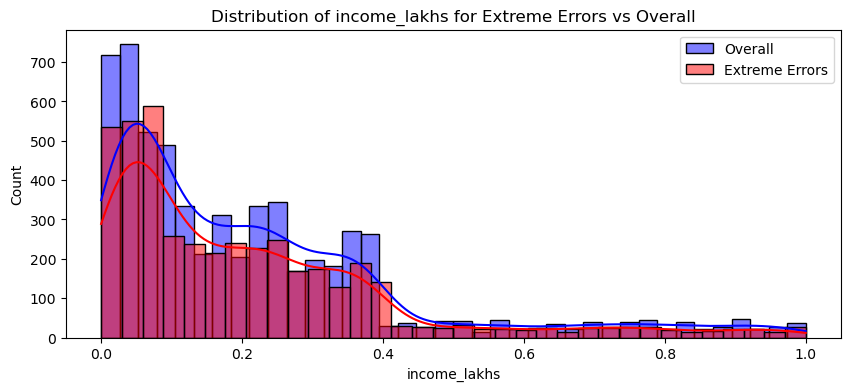

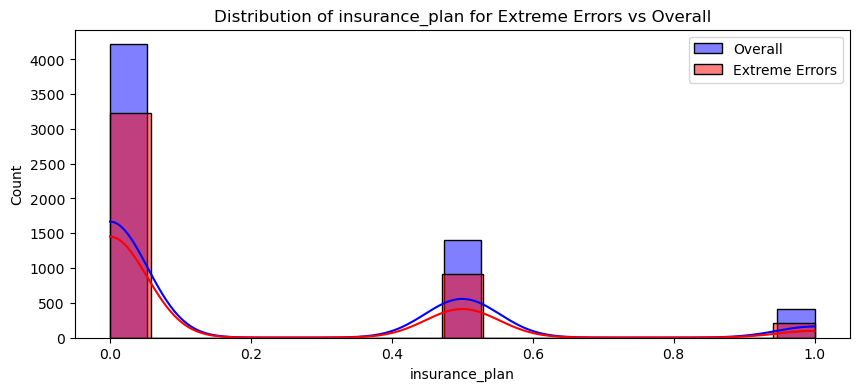

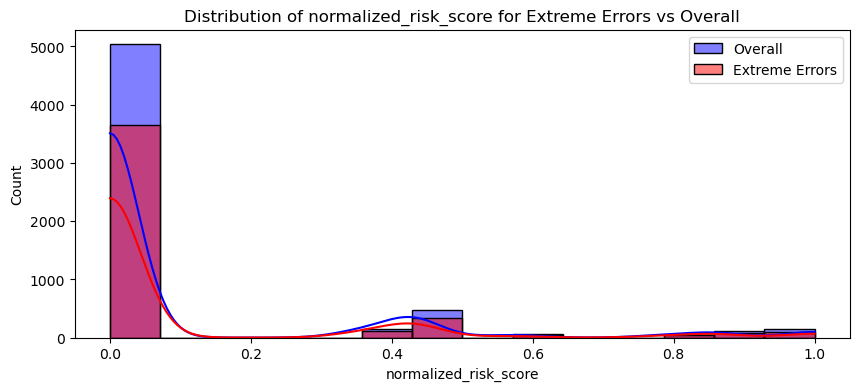

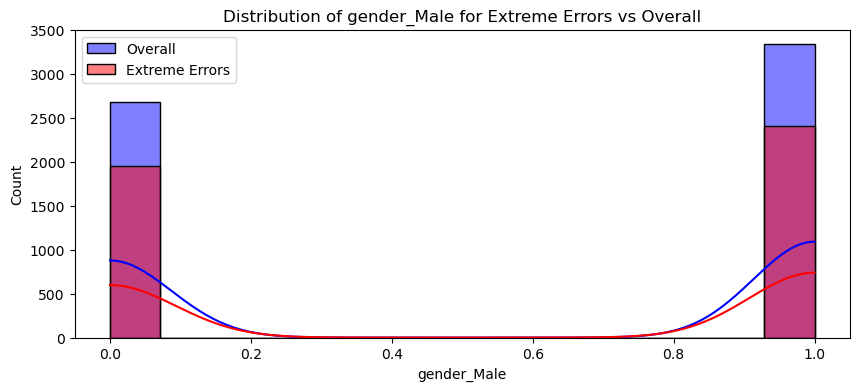

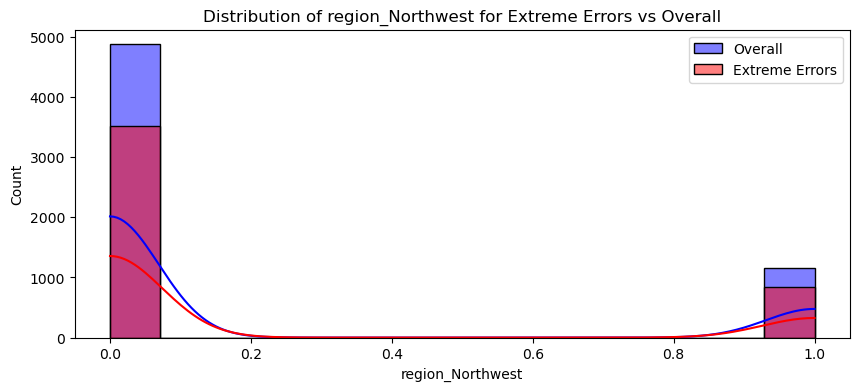

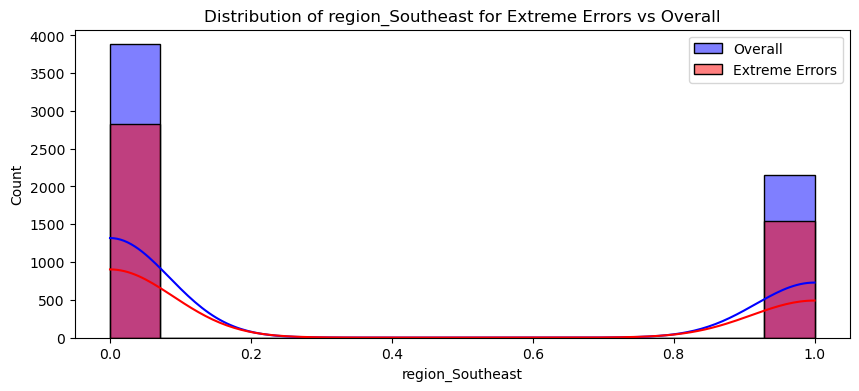

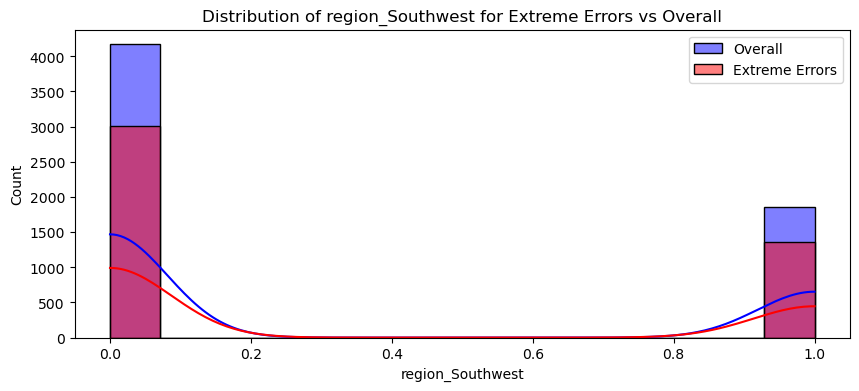

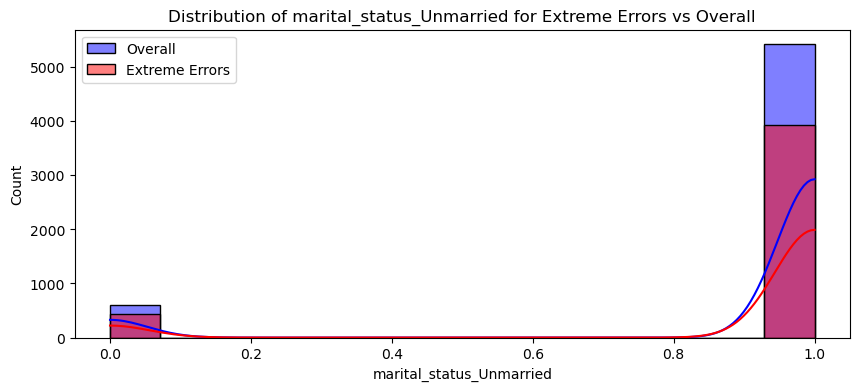

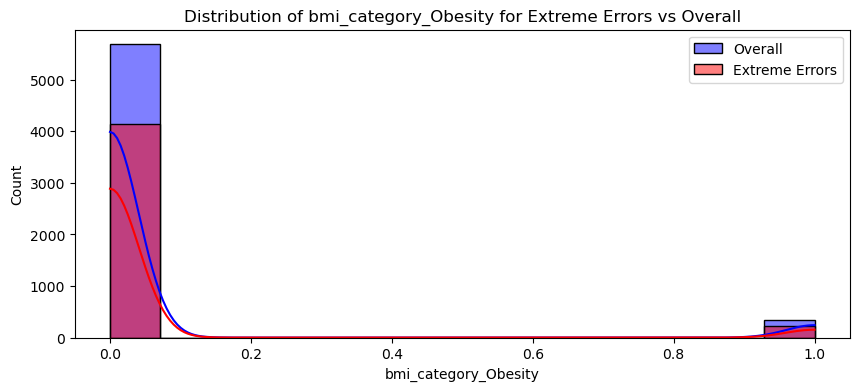

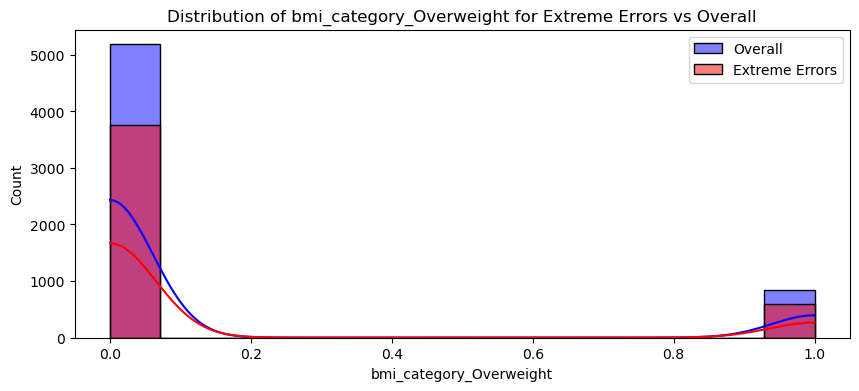

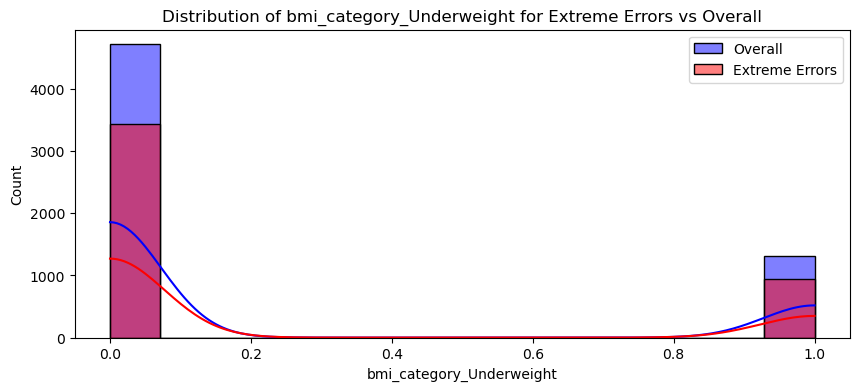

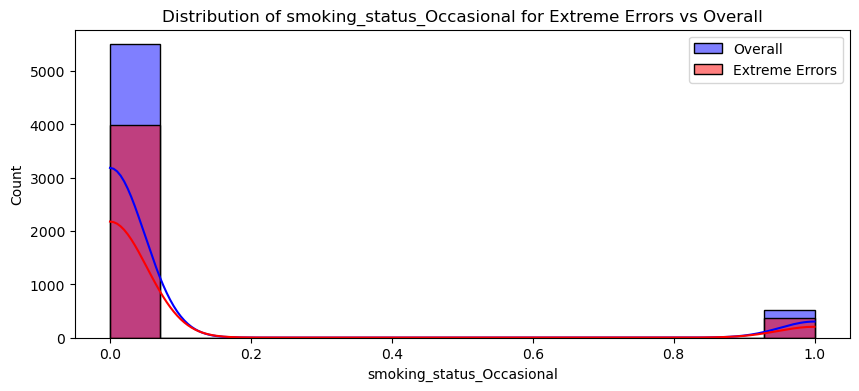

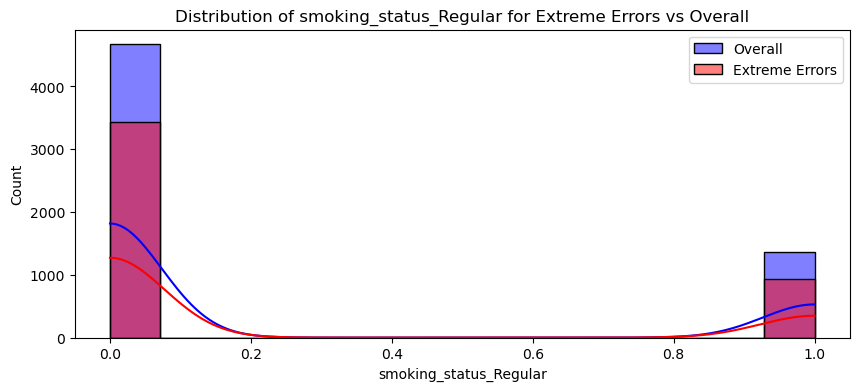

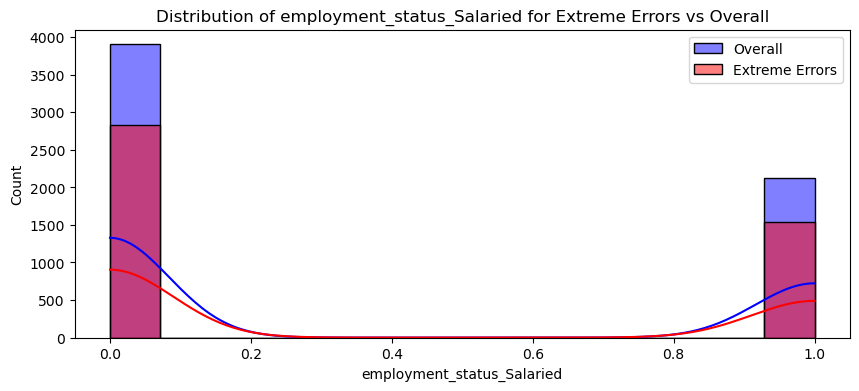

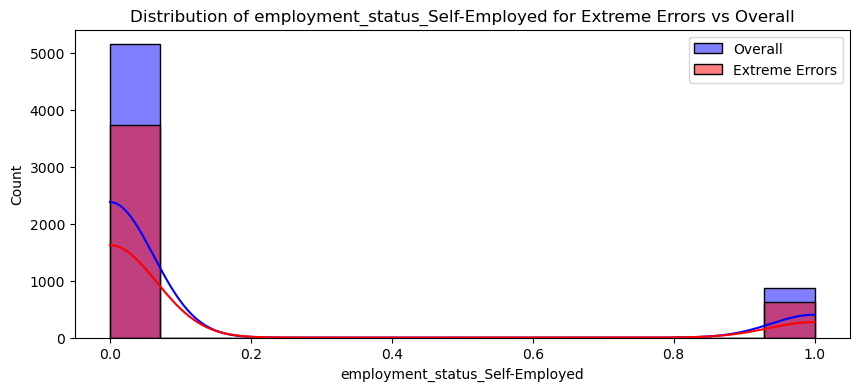

In [99]:
for feature in X_test.columns:
    plt.figure(figsize=(10, 4))
    sns.histplot(X_test[feature], color='blue', label='Overall', alpha=0.5, kde=True)
    sns.histplot(extreme_errors_df[feature], color='red', label='Extreme Errors', kde=True)
    plt.title(f'Distribution of {feature} for Extreme Errors vs Overall')
    plt.legend()
    plt.show()

* We can observe that there are some extreme errors in lower age group.
* We will do reverse sclaing to understand which age groups are showing such a high margin of errors.

In [84]:
cols_to_scale

['age',
 'number_of_dependants',
 'income_level',
 'income_lakhs',
 'insurance_plan']

In [85]:
extreme_errors_df.columns

Index(['unnamed:_0', 'age', 'number_of_dependants', 'income_lakhs',
       'insurance_plan', 'normalized_risk_score', 'gender_Male',
       'region_Northwest', 'region_Southeast', 'region_Southwest',
       'marital_status_Unmarried', 'bmi_category_Obesity',
       'bmi_category_Overweight', 'bmi_category_Underweight',
       'smoking_status_Occasional', 'smoking_status_Regular',
       'employment_status_Salaried', 'employment_status_Self-Employed'],
      dtype='object')

In [86]:
extreme_errors_df['income_level'] = -1 # adding column back again as it was removed because of high VIF
df_reversed = pd.DataFrame()
df_reversed[cols_to_scale] =  scaler.inverse_transform(extreme_errors_df[cols_to_scale])
df_reversed

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
0,21.0,3.0,-2.0,9.0,1.0
1,23.0,0.0,-2.0,4.0,1.0
2,19.0,0.0,-2.0,37.0,1.0
3,21.0,0.0,-2.0,52.0,2.0
4,18.0,0.0,-2.0,23.0,1.0
...,...,...,...,...,...
4365,20.0,1.0,-2.0,5.0,1.0
4366,21.0,1.0,-2.0,19.0,1.0
4367,24.0,1.0,-2.0,1.0,3.0
4368,24.0,0.0,-2.0,7.0,2.0


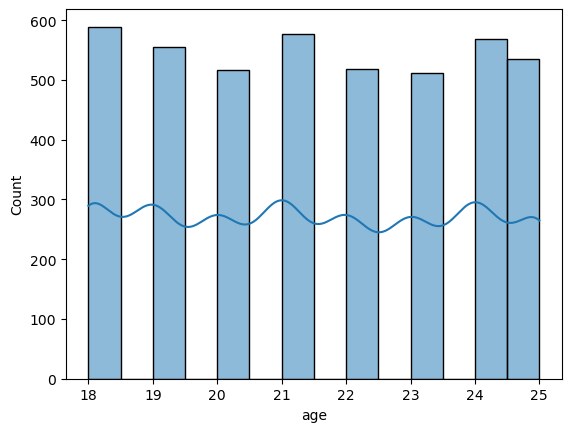

In [87]:
# Visual representation of age group

sns.histplot(df_reversed.age, kde=True)
plt.show()

In [88]:
df_reversed.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
count,4370.000000,4370.000000,4370.0,4370.000000,4370.000000
mean,21.456293,0.709382,-2.0,21.593593,1.309382
std,2.312611,0.942246,0.0,20.530146,0.560326
min,18.000000,0.000000,-2.0,1.000000,1.000000
25%,19.000000,0.000000,-2.0,7.000000,1.000000
50%,21.000000,0.000000,-2.0,16.000000,1.000000
75%,24.000000,1.000000,-2.0,31.000000,2.000000
max,25.000000,3.000000,-2.0,100.000000,3.000000


In [89]:
df_reversed['age'].quantile(0.97)

np.float64(25.0)

* 97% of the records in extreme errors data frame have age groups less than 25.